In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.losses import binary_crossentropy, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf

tf.config.list_physical_devices('GPU')

2023-03-07 19:32:03.834482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 19:32:05.929293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 19:32:05.962463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 19:32:05.971734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUM

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
data = np.load("mutations_coverage_prediction.npz")
max_len = 5000
X, Y = data['x'], data['y']
X = X.reshape((X.shape[0],X.shape[1]//40,40))
Y = Y.reshape((Y.shape[0],1))

train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1)
del X
del Y
del data

print ('Training:', train_x.shape, train_y.shape)
print ('Validation:', val_x.shape, val_y.shape)
print ('Test:', test_x.shape, test_y.shape)

Training: (72440, 125, 40) (72440, 1)
Validation: (8944, 125, 40) (8944, 1)
Test: (8049, 125, 40) (8049, 1)


In [3]:
# Base model
model = Sequential()
model.add(Conv1D(512, kernel_size=3, activation='relu', input_shape=train_x[0].shape))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(1, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.L2(1e-4),
          activity_regularizer=regularizers.L2(1e-5)))
model.summary()
adam = Adam(learning_rate=0.000005)
model.compile(optimizer=adam, loss=mean_squared_error)

2023-03-07 19:32:10.427998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 19:32:10.429391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 19:32:10.429569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 19:32:10.429692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 123, 512)          61952     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 61, 512)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 61, 512)           2099200   
                                                                 
 dense (Dense)               (None, 61, 1)             513       
                                                                 
Total params: 2,161,665
Trainable params: 2,161,665
Non-trainable params: 0
_________________________________________________________________


In [4]:
es = EarlyStopping(monitor='val_mae', patience=7)

filepath = 'best_model_lstm_cnn_checkpoint.h5'

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

history = model.fit(train_x, train_y,
                    batch_size=64,
                    epochs=100,
                    validation_data=(val_x, val_y),
                    callbacks =[es, checkpoint])

Epoch 1/100


2023-03-07 19:32:12.851619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-07 19:32:13.780950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1132/1132 [==============================] - ETA: 0s - loss: 13.0658 - mae: 2.7849
Epoch 1: val_loss improved from inf to 8.20642, saving model to best_model_lstm_cnn_checkpoint.h5
1132/1132 [==============================] - 11s 8ms/step - loss: 13.0658 - mae: 2.7849 - val_loss: 8.2064 - val_mae: 2.2781
Epoch 2/100
1125/1132 [============================>.] - ETA: 0s - loss: 8.0188 - mae: 2.2422
Epoch 2: val_loss improved from 8.20642 to 7.91064, saving model to best_model_lstm_cnn_checkpoint.h5
1132/1132 [==============================] - 8s 7ms/step - loss: 8.0221 - mae: 2.2422 - val_loss: 7.9106 - val_mae: 2.2384
Epoch 3/100
1126/1132 [============================>.] - ETA: 0s - loss: 7.7862 - mae: 2.2083
Epoch 3: val_loss improved from 7.91064 to 7.77000, saving model to best_model_lstm_cnn_checkpoint.h5
1132/1132 [==============================] - 8s 7ms/step - loss: 7.7918 - mae: 2.2093 - val_loss: 7.7700 - val_mae: 2.2163
Epoch 4/100
1125/1132 [============================>.] -

In [5]:
from keras.models import load_model
model.load_weights("best_model_lstm_cnn_checkpoint.h5")
test_loss = model.evaluate(test_x, test_y)
test_loss

252/252 [==============================] - 1s 3ms/step - loss: 7.4793 - mae: 2.1525


[7.479348659515381, 2.152470588684082]

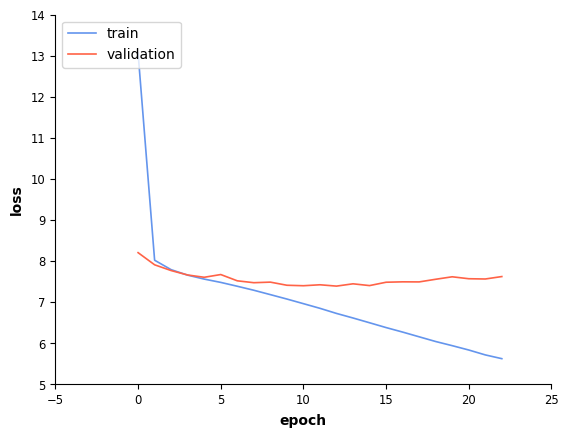

In [6]:
plt.style.use('apa')
# summarize history for loss
plt.plot(history.history['loss'], color='cornflowerblue',alpha=1)
plt.plot(history.history['val_loss'],color='tomato',alpha=1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()